In [1]:
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
import numpy

sys.path.append('../../timeseries/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from sklearn.covariance import EmpiricalCovariance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from exp_utils import *

'''
sys.path.append('../../timeseries/kalman-jax-master')
from jax.experimental import optimizers
#from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot
'''
def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def train_linear_SSM(x_tr, dz, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm = state_models.LinearStateModel(dz)
    om = observation_models.LinearObservationModel(dx, dz, noise_x=1.)
    
    if init_w_pca == 1:
        om.pca_init(x_tr, smooth_window=smooth_window)
        
    ssm_em_lin = StateSpaceEM(x_tr, observation_model=om, state_model=sm)
    ssm_em_lin.run()
    
    return ssm_em_lin


def train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm_hs = state_models.LinearStateModel(dz)
    om_hs = observation_models.HCCovObservationModel(dx, dz, du)
    if init_w_pca == 1:
        om_hs.pca_init(x_tr, smooth_window=20)
    hs_model = StateSpaceEM(x_tr, observation_model=om_hs, state_model=sm_hs)
    hs_model.run()
    
    return hs_model

In [2]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_energy_e1()

In [3]:
smooth_window = 20
dz, du = observation_models.recommend_dims(x_tr, smooth_window=20)

(3, 3)

In [4]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_energy_e1()
ssm_em_lin = train_linear_SSM(x_tr, dz, init_w_pca=True, smooth_window=smooth_window)
ssm_em_lin.save(model_name='ssm_em_lin_energy', path='../../data/models/')

Iteration 2 - llk=-2821.0
Iteration 4 - llk=-1851.6
Iteration 6 - llk=-1378.8
Iteration 8 - llk=-1131.1
Iteration 10 - llk=-1033.5
Iteration 12 - llk=-964.3
Iteration 14 - llk=-900.1
Iteration 16 - llk=-850.9
Iteration 18 - llk=-819.4
Iteration 20 - llk=-800.0
Iteration 22 - llk=-787.6
Iteration 24 - llk=-778.9
Iteration 26 - llk=-772.4
Iteration 28 - llk=-767.3
Iteration 30 - llk=-762.9
Iteration 32 - llk=-759.1
Iteration 34 - llk=-755.5
Iteration 36 - llk=-752.1
Iteration 38 - llk=-748.7
Iteration 40 - llk=-745.1
Iteration 42 - llk=-741.3
Iteration 44 - llk=-737.3
Iteration 46 - llk=-733.0
Iteration 48 - llk=-728.5
Iteration 50 - llk=-723.8
Iteration 52 - llk=-719.1
Iteration 54 - llk=-714.7
Iteration 56 - llk=-710.6
Iteration 58 - llk=-707.1
Iteration 60 - llk=-704.1
Iteration 62 - llk=-701.5
Iteration 64 - llk=-699.4
Iteration 66 - llk=-697.7
Iteration 68 - llk=-696.2
EM did converge.


In [5]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_energy_e1()
ssm_em_hsk = train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=True, smooth_window=smooth_window)
ssm_em_hsk.save(model_name='ssm_em_hsk_energy', path='../../data/models/')

Iteration 2 - llk=-1216.6
Iteration 4 - llk=-809.3
Iteration 6 - llk=-721.8
Iteration 8 - llk=-649.9
Iteration 10 - llk=-618.8
Iteration 12 - llk=-606.2
Iteration 14 - llk=-593.2
Iteration 16 - llk=-580.6
Iteration 18 - llk=-565.9
Iteration 20 - llk=-549.8
Iteration 22 - llk=-538.6
Iteration 24 - llk=-527.4
Iteration 26 - llk=-518.1
Iteration 28 - llk=-508.0
Iteration 30 - llk=-498.8
Iteration 32 - llk=-490.1
Iteration 34 - llk=-484.4
EM did converge.


In [7]:
ssm_em_hsk = load_model(model_name='ssm_em_hsk_energy', path='../../data/models/')
ssm_em_lin = load_model(model_name='ssm_em_lin_energy', path='../../data/models/')

In [8]:
ssm_em_lin.compute_predictive_log_likelihood(x_te)

-1589.4755942218233

In [16]:
ssm_em_hsk.compute_predictive_log_likelihood(x_te)

-1157.9546717677083

In [10]:
pred_hsk = ssm_em_hsk.compute_predictive_density(x_te)
pred_lin = ssm_em_lin.compute_predictive_density(x_te)

Text(0.5, 0, 'Time steps')

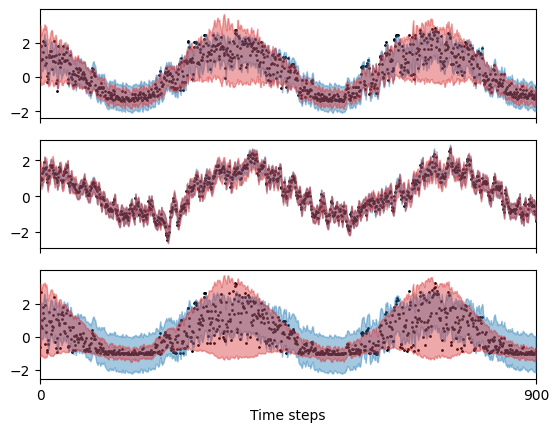

In [15]:
pyplot.rcdefaults()
mu_hsk, std_hsk = pred_hsk.mu, numpy.sqrt(pred_hsk.Sigma.diagonal(axis1=1, axis2=2))
mu_lin, std_lin = pred_lin.mu, numpy.sqrt(pred_lin.Sigma.diagonal(axis1=1, axis2=2))

fig = pyplot.figure()
for idx in range(3):
    ax = fig.add_subplot(3,1,idx+1)
    pyplot.plot(x_te[10:1010,idx], 'k.', ms=2)
    pyplot.fill_between(range(900), mu_hsk[10:910,idx] - 1.68 * std_hsk[10:910,idx], mu_hsk[10:910,idx] + 1.68 * std_hsk[10:910,idx], color='C3', alpha=.4, zorder=9, label='heterosk.')
    pyplot.fill_between(range(900), mu_lin[10:910,idx] - 1.68 * std_lin[10:910,idx], mu_lin[10:910,idx] + 1.68 * std_lin[10:910,idx], color='C0', alpha=.4, zorder=7, label='homosk.')
    pyplot.xlim([0,900])
    pyplot.xticks([0,900], labels=[])
    pyplot.yticks([-2,0,2])
    #pyplot.ylim([-3,3])
pyplot.xticks([0,900], labels=[0,900])
#pyplot.legend(frameon=False)
idx = 2
pyplot.xlabel('Time steps')
#pyplot.plot(mu_hsk[:1000,idx], color='C0')
#pyplot.plot(mu_hsk[:1000,idx], color='C3')